# Helthcare Insurance Cost

En este notebook se va a realizar el estudio de ciertas variables que pueden afectar al precio final del seguro médico que una persona quiera adquirir en esta compañía. Para ello, nos vamos a basar en los datos de otros clientes y los precios que han tenido en base a ciertos parametros que describiremos luego.

## Librerias

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
import joblib

## Funciones AUX

In [3]:
# Función para obtener el valor medio de edad según los criterios disponibles
def rellenar_edad(row, df):
    if not np.isnan(row['age']):
        return row['age']
    
    filters = []

    if not pd.isna(row['charges']):
        filters.append(('charges', row['charges']))
    if not pd.isna(row['smoker']):
        filters.append(('smoker', row['smoker']))
    if not pd.isna(row['children']):
        filters.append(('children', row['children']))
    
    # Intentar usar la combinación más completa posible
    for r in range(len(filters), 0, -1):
        for subset in itertools.combinations(filters, r):
            cond = np.ones(len(df), dtype=bool)
            for col, val in subset:
                cond &= (df[col] == val)
            mean_age = df.loc[cond, 'age'].mean()
            if not np.isnan(mean_age):
                return mean_age
    
    return np.nan  # Si no se puede inferir


In [4]:
def imputar_sex_por_charges(df):
    df = df.copy()

    # Filas con y sin sexo
    df_with_sex = df[df['sex'].notna()].copy()
    df_missing_sex = df[df['sex'].isna()].copy()

    # Verifica si hay algo que imputar
    if df_missing_sex.empty:
        return df

    # Columnas categóricas a codificar
    cols_to_encode = ['smoker', 'region']
    encoders = {}

    # Codificar columnas categóricas en df_with_sex
    for col in cols_to_encode:
        le = LabelEncoder()
        df_with_sex[col] = df_with_sex[col].astype(str)
        df_with_sex[col] = le.fit_transform(df_with_sex[col])
        encoders[col] = le

    # Codificar variable objetivo (sex)
    le_sex = LabelEncoder()
    df_with_sex['sex'] = le_sex.fit_transform(df_with_sex['sex'])

    # Variables para el modelo
    features = ['age', 'bmi', 'children', 'smoker', 'region', 'charges']

    # Imputar NaNs en X
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(df_with_sex[features])
    y_train = df_with_sex['sex']

    # Entrenar modelo
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Preparar df_missing_sex: codificar igual
    for col in cols_to_encode:
        df_missing_sex[col] = df_missing_sex[col].astype(str)
        df_missing_sex[col] = encoders[col].transform(df_missing_sex[col])

    # Imputar NaNs y predecir sex
    X_missing = imputer.transform(df_missing_sex[features])
    preds = model.predict(X_missing)
    pred_labels = le_sex.inverse_transform(preds)

    # Asignar predicciones al DataFrame original
    df.loc[df['sex'].isna(), 'sex'] = pred_labels

    return df

In [5]:
def imputar_bmi(df):
  df = df.copy()

  df_con_bmi = df[df['bmi'].notna()].copy()
  df_sin_bmi = df[df['bmi'].isna()].copy()

   #si no hay valores vacios se devuelve el df
  if df_sin_bmi.empty:
      return df
   
  cols_to_encode = ['sex', 'smoker', 'region']
  encoders = {}

  for col in cols_to_encode:
    le = LabelEncoder()
    df_con_bmi[col] = df_con_bmi[col].astype(str)
    df_con_bmi[col] = le.fit_transform(df_con_bmi[col])
    encoders[col] = le

  features = ['age', 'bmi', 'children', 'smoker', 'region', 'charges']

   # Imputar NaNs en X
  imputer = SimpleImputer(strategy='mean')
  X_train = imputer.fit_transform(df_con_bmi[features])
  y_train = df_con_bmi['bmi']

   # Entrenar modelo
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train, y_train)

  for col in cols_to_encode:
      df_sin_bmi[col] = df_sin_bmi[col].astype(str)
      df_sin_bmi[col] = encoders[col].transform(df_sin_bmi[col])

  # Imputar NaNs y predecir sex
  X_missing = imputer.transform(df_sin_bmi[features])
  preds = model.predict(X_missing)

  # Asignar predicciones al DataFrame original
  df.loc[df['bmi'].isna(), 'bmi'] = preds

  return df

## Lectura del dataset

In [6]:
#Dataset de entrenamiento
df = pd.read_csv('./data/insurance.csv')

In [7]:
df_val = pd.read_csv('./data/validation_dataset.csv')

## EDA

In [8]:
print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


In [9]:
df.describe()

,age,bmi,children
count,1272.000000,1272.000000,1272.000000
mean,35.214623,30.560550,0.948899
std,22.478251,6.095573,1.303532
min,-64.000000,15.960000,-4.000000
25%,24.750000,26.180000,0.000000
50%,38.000000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


Se puede observar como en los datos numéricos tenemos fallos, la edad minima es de -64 y en alguna fila aparece que el numero de hijos son -4. Tendremos que tener esto encuenta a la hora de limpiar datos

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


Todas las columnas presentan datos nulos, ya que el total de filas es 1338 y ninguna caracteristica tiene dicho valor. Deberemos revisar esto a la hora de realizar la limpieza para que nos quedemos con la información de valor.
Charges que es nuestro valor a predecir parece que es un objeto cuando este deberia ser un valor.

In [11]:
df.describe(include= ['object'])

,sex,smoker,region,charges
count,1272,1272,1272,1284
unique,6,2,8,1272
top,male,no,Southeast,$nan
freq,517,1013,172,12


- 6 tipos distintos de sexo -> hay que remplazar valores para male o female
- smoker parace estar bien aunque deberemo hacer label encoding para que sea representable
- charges -> parece que es el simbolo $ lo que está provocando el que sea un objeto esta columa

In [12]:
df['region'].value_counts()

region
Southeast    172
southeast    170
southwest    164
Northwest    161
Northeast    155
northeast    153
northwest    149
Southwest    148
Name: count, dtype: int64

Solo hay 3 regiones en total, debemos de corregir esto.

In [13]:
df['smoker'].value_counts()

smoker
no     1013
yes     259
Name: count, dtype: int64

In [14]:
df['sex'].value_counts()

sex
male      517
female    503
M          64
man        64
F          62
woman      62
Name: count, dtype: int64

## Data transformation

In [15]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.924
1,18.0,male,33.77,1.0,no,Southeast,1725.5523


### 1. corregir columna charges

In [16]:
df[df['charges'].astype(str).str.contains('\$', na=False)]

,age,sex,bmi,children,smoker,region,charges
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552
5,-31.0,woman,25.740,0.0,no,southeast,$3756.6216
8,37.0,male,29.830,2.0,no,Northeast,$6406.4107
...,...,...,...,...,...,...,...
1305,24.0,woman,27.720,0.0,no,southeast,$2464.6188
1307,32.0,male,28.120,4.0,yes,Northwest,$21472.4788
1331,23.0,female,33.400,0.0,no,southwest,$10795.93733
1333,50.0,male,30.970,3.0,no,Northwest,$10600.5483


In [17]:
df[~df['charges'].astype(str).str.contains('\$', na=False)]

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.924
1,18.0,male,33.77,1.0,no,Southeast,1725.5523
6,46.0,woman,33.44,1.0,no,southeast,8240.5896
7,37.0,female,27.74,3.0,no,Northwest,7281.5056
9,60.0,female,25.84,0.0,no,northwest,28923.13692
...,...,...,...,...,...,...,...
1330,57.0,female,25.74,2.0,no,Southeast,12629.1656
1332,52.0,female,44.70,3.0,no,southwest,11411.685
1334,-18.0,female,31.92,0.0,no,Northeast,2205.9808
1336,21.0,female,25.80,0.0,no,southwest,2007.945


In [18]:
df['charges'].info

<bound method Series.info of 0          16884.924
1          1725.5523
2          $4449.462
3       $21984.47061
4         $3866.8552
            ...     
1333     $10600.5483
1334       2205.9808
1335      $1629.8335
1336        2007.945
1337      29141.3603
Name: charges, Length: 1338, dtype: object>

1071 + 267 = 1338 que es el numero total de filas no nulas que hay en la columna, por tanto, como vemos, este es el causante del problema. vamos a corregirlo para que podamos tener los valores normales.

In [19]:
df_fixed = df.copy()

In [20]:
df_fixed['charges'] = df_fixed['charges'].astype(str).str.replace('\$', '', regex=True)

In [21]:
df_fixed['charges'] = pd.to_numeric(df_fixed['charges'], errors='coerce')
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1272 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.3+ KB


Con esto hemos conseguido transformar los valores de charge para que sean utiles!!

### 2. Age negative values

In [22]:
df_fixed[df_fixed['age'] <= 0]

,age,sex,bmi,children,smoker,region,charges
5,-31.0,woman,25.740,0.0,no,southeast,3756.62160
14,-27.0,male,42.130,0.0,yes,southeast,39611.75770
17,-23.0,male,23.845,0.0,no,northeast,2395.17155
23,-34.0,female,NaN,1.0,yes,NaN,37701.87680
79,-41.0,female,32.965,-0.0,no,Northwest,6571.02435
...,...,...,...,...,...,...,...
1278,-39.0,male,29.925,1.0,yes,northeast,22462.04375
1291,-19.0,male,34.900,0.0,yes,southwest,34828.65400
1303,-43.0,male,27.800,0.0,yes,southwest,37829.72420
1311,-33.0,female,26.695,0.0,no,northwest,4571.41305


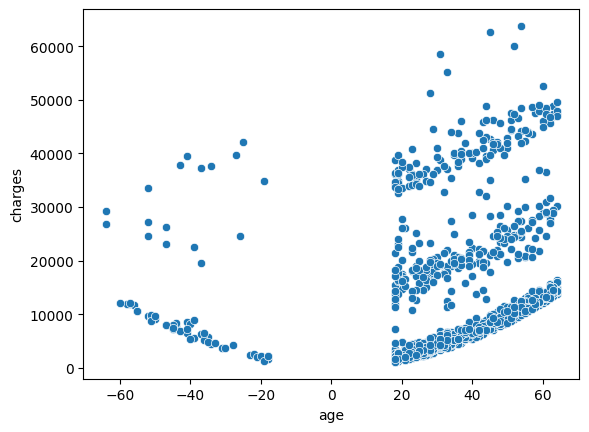

In [23]:
sns.scatterplot(df_fixed, y='charges', x='age')
plt.show()

A través de este scatterplot podemos observar varias cosas curiosas que nos pueden ayudar a resolver el problema. 
- Lo primero es que en las edades correctas hay 3 rangos muy diferenciados. Puedes que haya una caracteristica que haga que este valor pueda variar en 3 precios distintos para la misma edad.
- Lo segundo es que los valores negativos parecen tener un comportamiento 'invetido' con respecto a los normales, esto nos puede indicar que el fallo de esta columna es solo el menos y que se pasamos todos los valores a positivo se arrelgaría satisfactoriamente.

In [24]:
df_fixed['age'] = np.abs(df_fixed['age'])

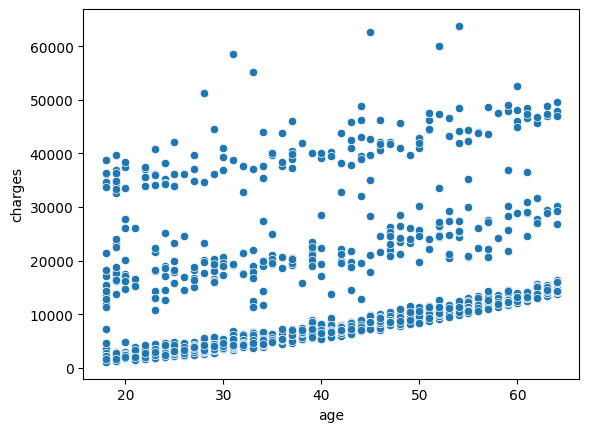

In [25]:
sns.scatterplot(df_fixed, y='charges', x='age')
plt.show()

Se puede ver como queda corregido y es coherente.

### 3. sex values

In [26]:
df_fixed.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,Southeast,1725.5523


In [27]:
df_fixed['sex'].value_counts()

sex
male      517
female    503
M          64
man        64
F          62
woman      62
Name: count, dtype: int64

In [28]:
df_fixed['sex'] = df_fixed['sex'].replace({
    'M' : 'male',
    'man' : 'male',
    'F' : 'female',
    'woman' : 'female'
})

df_fixed['sex'].value_counts()

sex
male      645
female    627
Name: count, dtype: int64

Corregido!!

### 4. bmi

In [29]:
df_fixed.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,Southeast,1725.5523


C:\Users\ferna\AppData\Local\Temp\ipykernel_7864\4026360163.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_fixed['bmi'], palette='pastel')


<Axes: ylabel='bmi'>

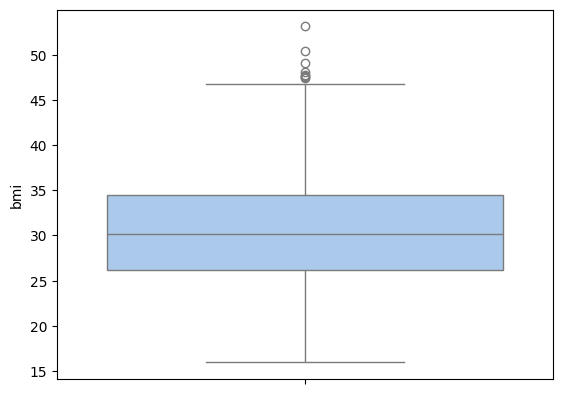

In [30]:
sns.boxplot(df_fixed['bmi'], palette='pastel')

Se puede apreciar como los valores parecen bastante normales. Lo unico es que existen OutLiers con BMI más alto de lo normal, que se estudiaran más adelante.

### 5. Children

In [31]:
df_fixed.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,Southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


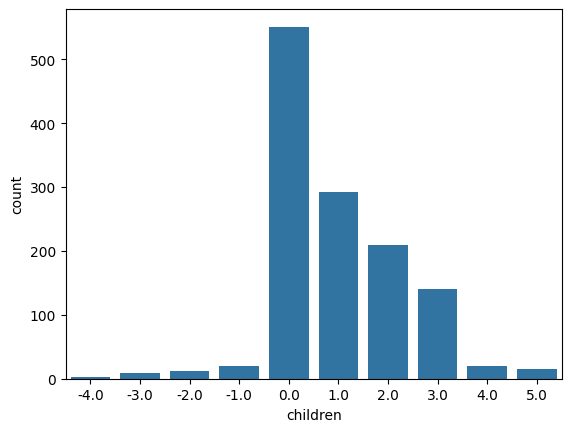

In [32]:
sns.barplot(df_fixed['children'].value_counts())
plt.show()

In [33]:
df_fixed[df_fixed['children'] < 0].shape

(44, 7)

In [34]:
df_fixed[df_fixed['children'] == -4]

,age,sex,bmi,children,smoker,region,charges
621,37.0,male,34.10,-4.0,yes,Southwest,40182.2460
1094,50.0,female,33.70,-4.0,no,southwest,11299.3430
1095,18.0,female,31.35,-4.0,no,Northeast,4561.1885


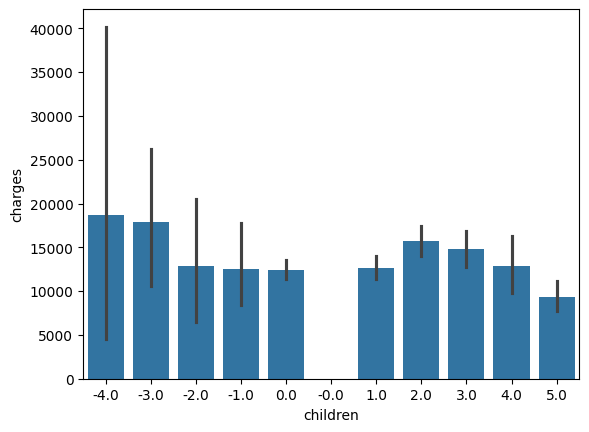

In [35]:
sns.barplot(x = df_fixed['children'], y= df_fixed['charges'])
plt.show()

No parece existir una asociación directa entre columnas y dar una explicación a los numero negativos. Como solo son 44 casos, vamos a eliminarlos.

In [36]:
df_fixed = df_fixed[df_fixed['children'] >= 0]
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1196 non-null   float64
 1   sex       1199 non-null   object 
 2   bmi       1196 non-null   float64
 3   children  1228 non-null   float64
 4   smoker    1193 non-null   object 
 5   region    1193 non-null   object 
 6   charges   1198 non-null   float64
dtypes: float64(4), object(3)
memory usage: 76.8+ KB


In [37]:
df_fixed.describe()

,age,bmi,children,charges
count,1196.000000,1196.000000,1228.000000,1198.000000
mean,39.297659,30.571564,1.050489,13253.926119
std,14.111808,6.117201,1.195233,12167.531890
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4676.641325
50%,39.000000,30.210000,1.000000,9289.083100
75%,51.000000,34.488750,2.000000,16584.318157
max,64.000000,53.130000,5.000000,63770.428010


### 6. Region

In [38]:
df_fixed.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,Southeast,1725.5523


In [39]:
df_fixed.region.value_counts()

region
Southeast    161
southeast    156
Northwest    153
southwest    151
Northeast    148
northwest    144
northeast    143
Southwest    137
Name: count, dtype: int64

In [40]:
df_fixed.region = df_fixed.region.replace({
                            'southeast' : 'Southeast',
                            'northwest' : 'Northwest',
                            'northeast' : 'Northeast',
                            'southwest' : 'Southwest'
                            })

In [41]:
df_fixed.region.value_counts()

region
Southeast    317
Northwest    297
Northeast    291
Southwest    288
Name: count, dtype: int64

In [42]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1196 non-null   float64
 1   sex       1199 non-null   object 
 2   bmi       1196 non-null   float64
 3   children  1228 non-null   float64
 4   smoker    1193 non-null   object 
 5   region    1193 non-null   object 
 6   charges   1198 non-null   float64
dtypes: float64(4), object(3)
memory usage: 76.8+ KB


## Correción de NaN y Duplicados

Como estamos intentando averiguar el precio para nuevos clientes, de aquellos que no dipongamos es mejor eliminarlos

In [43]:
df_fixed[df_fixed['charges'].isna()].shape

(30, 7)

In [44]:
df_fixed.dropna(subset=['charges'], inplace=True)

In [45]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1178 non-null   float64
 1   sex       1184 non-null   object 
 2   bmi       1178 non-null   float64
 3   children  1198 non-null   float64
 4   smoker    1180 non-null   object 
 5   region    1179 non-null   object 
 6   charges   1198 non-null   float64
dtypes: float64(4), object(3)
memory usage: 74.9+ KB


Age

In [46]:
df_fixed[df_fixed['age'].isna()]

,age,sex,bmi,children,smoker,region,charges
63,NaN,female,25.935,1.0,NaN,Northwest,4133.64165
210,NaN,NaN,33.000,1.0,NaN,NaN,1980.07000
259,NaN,male,NaN,0.0,NaN,NaN,33750.29180
270,NaN,male,NaN,1.0,no,NaN,1719.43630
513,NaN,male,NaN,0.0,no,NaN,1256.29900
567,NaN,NaN,30.590,2.0,no,Northwest,7256.72310
614,NaN,female,NaN,0.0,NaN,NaN,1880.07000
650,NaN,NaN,42.680,2.0,no,Southeast,9800.88820
755,NaN,male,NaN,2.0,no,NaN,5031.26955
770,NaN,male,NaN,3.0,NaN,Southwest,27941.28758


In [47]:
index_age_wrong = df_fixed[df_fixed['age'].isna()].index

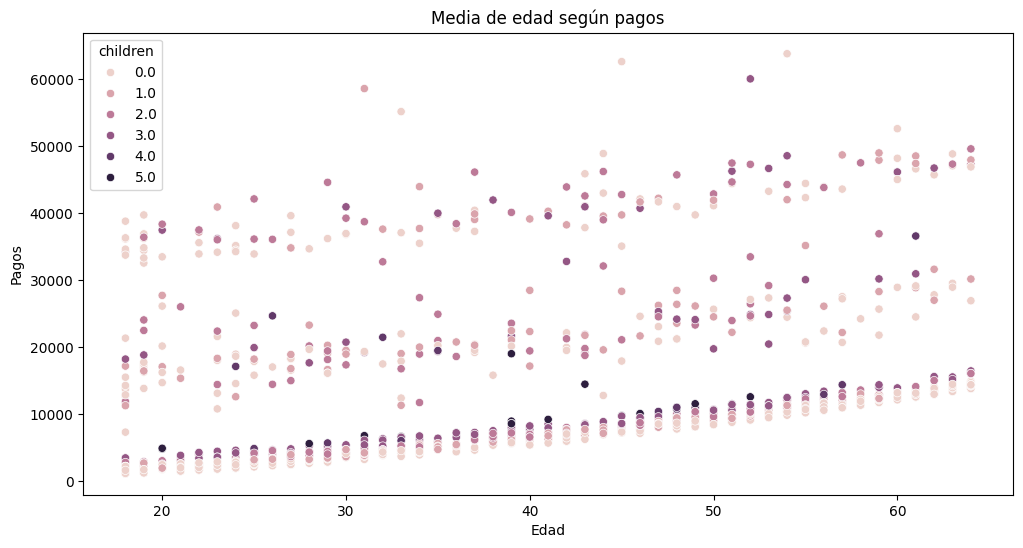

In [48]:
# age
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_fixed, x='age', y='charges', hue='children')

plt.title('Media de edad según pagos')
plt.xlabel('Edad')
plt.ylabel('Pagos')

plt.show()

In [49]:
df_fixed['age'] = df_fixed.apply(lambda row: rellenar_edad(row, df_fixed), axis=1)

In [50]:
df_fixed.loc[index_age_wrong]

,age,sex,bmi,children,smoker,region,charges
63,39.888889,female,25.935,1.0,NaN,Northwest,4133.64165
210,39.888889,NaN,33.000,1.0,NaN,NaN,1980.07000
259,38.264540,male,NaN,0.0,NaN,NaN,33750.29180
270,39.902655,male,NaN,1.0,no,NaN,1719.43630
513,38.834906,male,NaN,0.0,no,NaN,1256.29900
567,39.489933,NaN,30.590,2.0,no,Northwest,7256.72310
614,38.264540,female,NaN,0.0,NaN,NaN,1880.07000
650,39.489933,NaN,42.680,2.0,no,Southeast,9800.88820
755,39.489933,male,NaN,2.0,no,NaN,5031.26955
770,41.682171,male,NaN,3.0,NaN,Southwest,27941.28758


In [51]:
df_fixed['age'] = df_fixed['age'].round().astype('Int64')
df_fixed.loc[index_age_wrong]

,age,sex,bmi,children,smoker,region,charges
63,40,female,25.935,1.0,NaN,Northwest,4133.64165
210,40,NaN,33.000,1.0,NaN,NaN,1980.07000
259,38,male,NaN,0.0,NaN,NaN,33750.29180
270,40,male,NaN,1.0,no,NaN,1719.43630
513,39,male,NaN,0.0,no,NaN,1256.29900
567,39,NaN,30.590,2.0,no,Northwest,7256.72310
614,38,female,NaN,0.0,NaN,NaN,1880.07000
650,39,NaN,42.680,2.0,no,Southeast,9800.88820
755,39,male,NaN,2.0,no,NaN,5031.26955
770,42,male,NaN,3.0,NaN,Southwest,27941.28758


Sex

In [52]:
df_fixed[df_fixed['sex'].isna()].shape

(14, 7)

In [53]:
df_fixed[df_fixed['sex'].isna()].sort_values('charges')

,age,sex,bmi,children,smoker,region,charges
1296,38,NaN,26.125,0.0,NaN,Northeast,1708.92575
210,40,NaN,33.000,1.0,NaN,NaN,1980.07000
930,26,NaN,46.530,1.0,NaN,NaN,2927.06470
51,21,NaN,NaN,2.0,NaN,Northwest,3579.82870
1119,41,NaN,NaN,3.0,no,NaN,5693.43050
567,39,NaN,30.590,2.0,no,Northwest,7256.72310
367,42,NaN,NaN,2.0,no,Northwest,8017.06115
650,39,NaN,42.680,2.0,no,Southeast,9800.88820
1228,56,NaN,NaN,0.0,no,NaN,10594.22570
1135,41,NaN,28.120,3.0,no,Northwest,11085.58680


In [54]:
index_sex_wrong = df_fixed[df_fixed['sex'].isna()].index

Para este caso vamos a hacer un pequeño modelo predictivo basado en el resto de features para rellenar los valores NaN. Esto quedará reflejado en la sección de Funciones AUX con el nombre de ´imputar_sex_por_charges´

In [55]:
df_fixed = imputar_sex_por_charges(df_fixed)

In [56]:
df_fixed.loc[index_sex_wrong]

,age,sex,bmi,children,smoker,region,charges
51,21,male,NaN,2.0,NaN,Northwest,3579.82870
210,40,male,33.000,1.0,NaN,NaN,1980.07000
367,42,male,NaN,2.0,no,Northwest,8017.06115
567,39,female,30.590,2.0,no,Northwest,7256.72310
650,39,male,42.680,2.0,no,Southeast,9800.88820
752,64,female,37.905,0.0,no,Northwest,14210.53595
806,40,male,NaN,1.0,NaN,NaN,28476.73499
893,40,male,NaN,2.0,yes,Southeast,44202.65360
930,26,female,46.530,1.0,NaN,NaN,2927.06470
1047,40,male,NaN,1.0,NaN,Southeast,44501.39820


In [57]:
df_fixed[df_fixed['sex'].isna()]

,age,sex,bmi,children,smoker,region,charges


BMI

In [58]:
df_fixed[df_fixed['bmi'].isna()].sort_values('charges')

,age,sex,bmi,children,smoker,region,charges
513,39,male,NaN,0.0,no,NaN,1256.29900
888,38,male,NaN,0.0,NaN,NaN,1682.59700
270,40,male,NaN,1.0,no,NaN,1719.43630
614,38,female,NaN,0.0,NaN,NaN,1880.07000
51,21,male,NaN,2.0,NaN,Northwest,3579.82870
952,40,female,NaN,1.0,no,Northwest,4527.18295
1312,40,male,NaN,1.0,NaN,Southwest,4536.25900
906,42,male,NaN,3.0,NaN,NaN,4846.92015
755,39,male,NaN,2.0,no,NaN,5031.26955
1119,41,male,NaN,3.0,no,NaN,5693.43050


In [59]:
index_bmi_wrong = df_fixed[df_fixed['bmi'].isna()].index

In [60]:
df_fixed = imputar_bmi(df_fixed)

In [61]:
df_fixed['bmi'] = df_fixed['bmi'].round(2)

In [62]:
df_fixed.loc[index_bmi_wrong]

,age,sex,bmi,children,smoker,region,charges
23,34,female,30.60,1.0,yes,NaN,37701.87680
51,21,male,30.59,2.0,NaN,Northwest,3579.82870
259,38,male,30.60,0.0,NaN,NaN,33750.29180
270,40,male,30.59,1.0,no,NaN,1719.43630
367,42,male,30.59,2.0,no,Northwest,8017.06115
415,43,female,30.59,1.0,no,NaN,7345.72660
513,39,male,30.59,0.0,no,NaN,1256.29900
614,38,female,30.59,0.0,NaN,NaN,1880.07000
755,39,male,30.59,2.0,no,NaN,5031.26955
770,42,male,30.60,3.0,NaN,Southwest,27941.28758


In [63]:
df_fixed[df_fixed['bmi'].isna()]

,age,sex,bmi,children,smoker,region,charges


Children

In [64]:
df_fixed[df_fixed['children'].isna()]

,age,sex,bmi,children,smoker,region,charges


smoker

In [65]:
print(df_fixed[df_fixed['smoker'].isna()].shape)
df_fixed[df_fixed['smoker'].isna()]

(18, 7)


,age,sex,bmi,children,smoker,region,charges
51,21,male,30.59,2.0,NaN,Northwest,3579.82870
63,40,female,25.94,1.0,NaN,Northwest,4133.64165
210,40,male,33.00,1.0,NaN,NaN,1980.07000
254,50,male,31.82,0.0,NaN,NaN,41097.16175
259,38,male,30.60,0.0,NaN,NaN,33750.29180
542,63,female,36.30,0.0,NaN,NaN,13887.20400
597,34,female,33.25,1.0,NaN,NaN,5594.84550
614,38,female,30.59,0.0,NaN,NaN,1880.07000
770,42,male,30.60,3.0,NaN,Southwest,27941.28758
774,41,male,34.20,2.0,NaN,NaN,7261.74100


In [66]:
df_fixed['smoker'].fillna(df_fixed['smoker'].mode()[0], inplace=True)

C:\Users\ferna\AppData\Local\Temp\ipykernel_7864\3222379783.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fixed['smoker'].fillna(df_fixed['smoker'].mode()[0], inplace=True)


In [67]:
df_fixed[df_fixed['smoker'].isna()]

,age,sex,bmi,children,smoker,region,charges


region

In [68]:
print(df_fixed[df_fixed['region'].isna()].shape)
df_fixed[df_fixed['region'].isna()]

(19, 7)


,age,sex,bmi,children,smoker,region,charges
23,34,female,30.60,1.0,yes,NaN,37701.87680
210,40,male,33.00,1.0,no,NaN,1980.07000
254,50,male,31.82,0.0,no,NaN,41097.16175
259,38,male,30.60,0.0,no,NaN,33750.29180
270,40,male,30.59,1.0,no,NaN,1719.43630
415,43,female,30.59,1.0,no,NaN,7345.72660
513,39,male,30.59,0.0,no,NaN,1256.29900
542,63,female,36.30,0.0,no,NaN,13887.20400
597,34,female,33.25,1.0,no,NaN,5594.84550
614,38,female,30.59,0.0,no,NaN,1880.07000


In [69]:
df_fixed['region'].fillna(df_fixed['region'].mode()[0], inplace=True)

C:\Users\ferna\AppData\Local\Temp\ipykernel_7864\3645828297.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fixed['region'].fillna(df_fixed['region'].mode()[0], inplace=True)


In [70]:
df_fixed[df_fixed['region'].isna()]

,age,sex,bmi,children,smoker,region,charges


In [71]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1198 non-null   Int64  
 1   sex       1198 non-null   object 
 2   bmi       1198 non-null   float64
 3   children  1198 non-null   float64
 4   smoker    1198 non-null   object 
 5   region    1198 non-null   object 
 6   charges   1198 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 108.3+ KB


Ya tenemos todo el dataset corregido sin valores a NaN por tanto podemos pasar a la preparación del dataset y modelado.

## Pipeline de procesamiento/entrenamiento

In [72]:
X = df_fixed.drop('charges', axis=1) 
y = df_fixed['charges']

# Detectar tipos de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [73]:
# Pipeline para numéricos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para categóricos
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

## Entrenamiento y Predicción

Random Forest Regressor

In [74]:
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar
pipeline.fit(X_train, y_train)

# Predecir
y_pred = pipeline.predict(X_test)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

RMSE: 5331.00


In [75]:
# Calculate the R squared score
r2_score = r2_score(y_test, y_pred)
print(f'r2_score: {r2_score:.2f}')

r2_score: 0.82


XGBoost

In [76]:
model = XGBRegressor(objective='reg:squarederror', random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

In [79]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🔍 Best params: {grid_search.best_params_}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² score: {r2:.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
✅ RMSE: 5172.54
✅ R² score: 0.83


XGBoost con cálculo de percentiles

In [80]:
# Calcular los percentiles
q1 = df_fixed['charges'].quantile(0.25)
q3 = df_fixed['charges'].quantile(0.75)


df_iqr = df_fixed[(df_fixed['charges'] >= q1) & (df_fixed['charges'] <= q3)]

In [81]:
X = df_iqr.drop('charges', axis=1) 
y = df_iqr['charges']

# Detectar tipos de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [82]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔍 Best params: {grid_search.best_params_}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² score: {r2:.2f}")


joblib.dump(best_model, "best_model.pkl")
print("💾 Modelo guardado en 'best_model.pkl'")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
✅ RMSE: 1018.35
✅ R² score: 0.88
💾 Modelo guardado en 'best_model.pkl'


## Conclusión


1. **Buen rendimiento general**  
   El modelo entrenado sobre los datos filtrados entre el percentil 25 (Q1) y 75 (Q3) de `charges` ha alcanzado un rendimiento muy satisfactorio, con un **RMSE de 1018.35** y un **R² de 0.88**. Esto indica que el error promedio de predicción es relativamente bajo y que el modelo logra explicar el **88% de la variabilidad** en los gastos médicos.

2. **Eliminación de outliers efectiva**  
   Al trabajar únicamente con el rango intercuartílico (IQR), se han eliminado valores extremos que podrían distorsionar el aprendizaje del modelo. Esto ha permitido un entrenamiento más estable y una evaluación más representativa del comportamiento del modelo en situaciones normales.

3. **Pipeline correctamente configurada**  
   El pipeline de preprocesamiento ha manejado de manera adecuada tanto las variables numéricas como categóricas, incluyendo imputación de valores faltantes, escalado y codificación. Esto ha sido clave para alcanzar un resultado sólido y reproducible.

4. **Capacidad predictiva adecuada para la tarea**  
   Con un R² cercano a 0.9, el modelo demuestra ser **altamente explicativo**, lo que sugiere que las variables seleccionadas (`age`, `bmi`, `smoker`, `sex`, etc.) contienen suficiente información para predecir los costos médicos con buena precisión.